In [1]:
import cv2
from scipy.spatial.transform import Rotation as Rot
from numpy.linalg import inv

import numpy as np
np.set_printoptions(precision=6, suppress=True)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib widget

In [2]:
def project(pts, M):
    pts = pts.copy()
    o = np.ones([pts.shape[0], 1])
    pts = np.concatenate([pts, o], axis=1)
    pts = pts @ M.T
    return pts[:, :2] / pts[:, 2:3]

def draw_poly(pts, edge_color='b', marker=None, vert_color='b'):
    plt.gca().add_patch(patches.Polygon(
        pts, closed=True, edgecolor=edge_color, fill=False))
    if marker is not None:
        plt.scatter(pts[:, 0], pts[:, 1], marker=marker)

def find_H(img1, img2):
    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    MIN_MATCH_COUNT = 10
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

        h,w,_ = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)

        img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        M = None
        matchesMask = None

    draw_params = dict(
        matchColor = (0,255,0), # draw matches in green color
        singlePointColor = None,
        matchesMask = matchesMask, # draw only inliers
        flags = 2)

    img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

    return M, img3

def draw_vec(ax, x, y, z, n='', c='black', r=0.2, **kwargs):
    e = 1.2
    ax.quiver(0,0,0,x,y,z,color=c, arrow_length_ratio=r)
    x,y,z = x*e, y*e, z*e
    ax.text(x,y,z,n,color=c,ha='center',va='center')

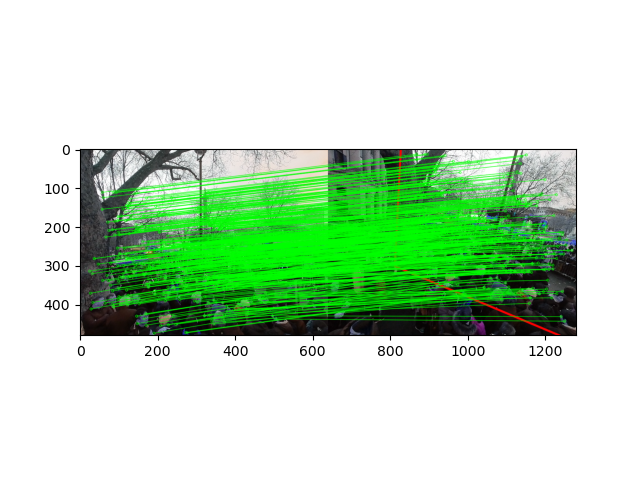

In [3]:
images = [
    cv2.imread(f'a{i}.jpg')
    for i in [0, 1]
]
H_cv2, corr_img = find_H(images[0], images[1])
plt.imshow(corr_img, 'gray')
plt.show()

In [6]:
pts = np.array([
    [-320,   -240],
    [320,   -240],
    [320, 240],
    [-320, 240],
])

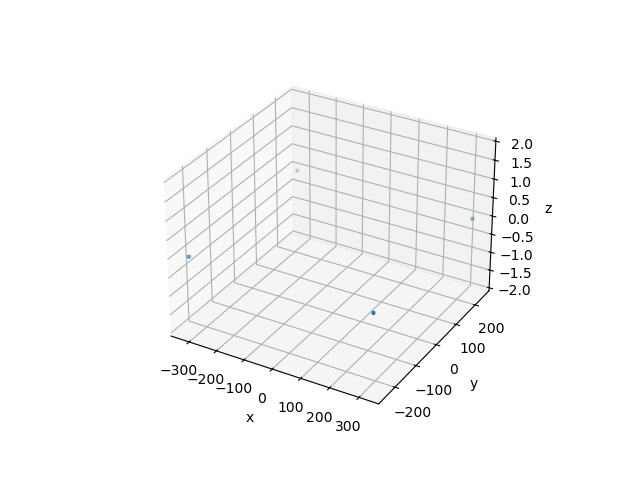

In [19]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.set_xlim(-2, 2)
#ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.scatter(pts[:, 0], pts[:, 1], s=5, marker='x')

#draw_vec(ax, 1, 0, 0, 'x')
#draw_vec(ax, 0, 1, 0, 'y')
#draw_vec(ax, 0, 0, 1, 'z')

plt.show()

In [40]:
f = 240 / np.tan(np.radians(37.5))
K = np.array([
    [f, 0, 0],
    [0, f, 0],
    [0, 0, 1],
])

a1 = [20, -15, 10]
R1 = Rot.from_euler('YXZ', a1, degrees=True).as_matrix()

ph = np.concatenate([pts, np.ones([pts.shape[0], 1])], axis=1)

pts1 = K @ inv(R1) @ inv(K) @ ph.T
pts1

array([[-450.029152,  132.399655,  212.91066 , -369.518148],
       [-204.525732, -364.751268,   91.849329,  252.074865],
       [   0.371076,    1.047073,    1.444271,    0.768274]])

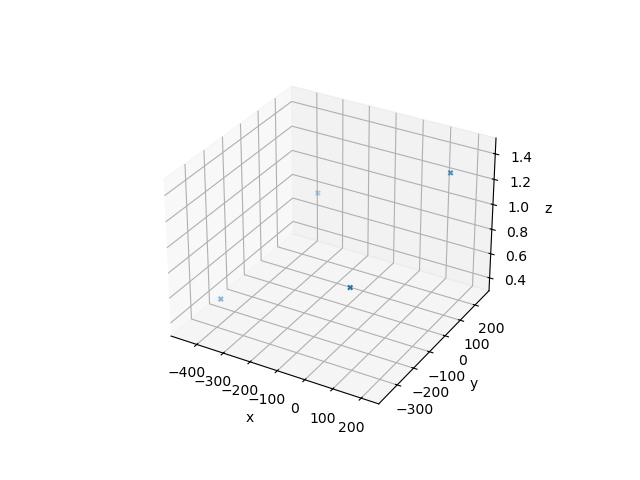

In [41]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.set_xlim(-2, 2)
#ax.set_ylim(-2, 2)
#ax.set_zlim(-2, 2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.scatter(pts1[0, :], pts1[1, :], pts1[2, :], s=10, marker='x')
plt.show()